# 05 Segmentation & ROI 

This notebook four-quadrant segmentation (Persuadables / Sure Things / Lost Causes / Sleeping Dogs) on the full sample, conducts ROI simulations

## Section 0: Setup

In [2]:
# ======================================================
# Section 0 (Cell 1/1): Setup
# ======================================================
# Requirements:
# - Load hillstrom_features.csv + cate_vectors.npz + qini_results.json
# - Split X, T, Y
# - Print Phase 2 handoff checks
# - Select best learner CATE (expected: X-Learner)

import os
import sys
import json
import importlib
from pathlib import Path
from datetime import datetime, timezone, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from IPython.display import Markdown, display

# Timezone anchoring for reproducibility
TZ_UTC8 = timezone(timedelta(hours=8))
run_ts_utc8 = datetime.now(TZ_UTC8).strftime('%Y-%m-%d %H:%M:%S %z')
print(f"[UTC+8] Run timestamp: {run_ts_utc8}")

# Project root resolution (avoid hardcoding)
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
os.chdir(project_root)

# Plot style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 13
sns.set_palette('Set2')

# Load config (config.yml / config.yaml)
config_candidates = [project_root / 'configs' / 'config.yaml', project_root / 'configs' / 'config.yml']
config_path = next((p for p in config_candidates if p.exists()), None)
if config_path is None:
    raise FileNotFoundError(f"No config file found. Searched: {[str(p) for p in config_candidates]}")
with open(config_path, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

figures_dir = Path(config['paths']['figures_dir'])
figures_dir.mkdir(parents=True, exist_ok=True)
print(f"Figures will be saved to: {figures_dir}")

features_path = Path(config['paths']['features_data'])
cate_path = Path(config['paths']['cate_vectors'])
qini_path = Path(config['paths']['qini_results'])

assert features_path.exists(), f"Missing features file: {features_path}"
assert cate_path.exists(), f"Missing CATE vectors file: {cate_path} (run Notebook 04 Section 6 persist cell)"
assert qini_path.exists(), f"Missing Qini results file: {qini_path} (run Notebook 04 Section 6 persist cell)"

# Load features
df = pd.read_csv(features_path)
assert len(df) > 0, "Loaded features DataFrame is empty"
print(f"Loaded: {features_path}")

treatment_col = config['data']['treatment_col']
outcome_col = config['data']['outcome_col']
covariates = config['data']['covariates']

X = df[covariates].copy()
T = pd.to_numeric(df[treatment_col], errors='coerce').astype(int)
Y = pd.to_numeric(df[outcome_col], errors='coerce').astype(int)

assert X.isnull().sum().sum() == 0, "X contains NaN"
assert set(pd.unique(T)).issubset({0, 1}), "T must be binary (0/1)"
assert set(pd.unique(Y)).issubset({0, 1}), "Y must be binary (0/1)"

# Load CATE vectors
cate_npz = np.load(cate_path)
required_keys = {'cate_s', 'cate_t', 'cate_x'}
missing_keys = required_keys - set(cate_npz.files)
assert len(missing_keys) == 0, f"cate_vectors.npz missing keys: {sorted(list(missing_keys))}"

cate_s = np.asarray(cate_npz['cate_s'], dtype=float).reshape(-1)
cate_t = np.asarray(cate_npz['cate_t'], dtype=float).reshape(-1)
cate_x = np.asarray(cate_npz['cate_x'], dtype=float).reshape(-1)

assert len(cate_x) == len(df), f"CATE length mismatch: len(cate_x)={len(cate_x)}, len(df)={len(df)}"
assert np.isfinite(cate_x).all(), "cate_x contains NaN/inf"

# Load Qini results
with open(qini_path, 'r', encoding='utf-8') as f:
    qini_results = json.load(f)
assert 'meta' in qini_results, "qini_results.json missing meta"
best_learner = str(qini_results['meta'].get('best_learner', 'X'))
best_qini = float(qini_results['meta'].get('best_qini_coefficient', np.nan))

# Handoff check print (Phase 3 expects reading these artifacts)
cate_min = float(np.min(cate_x))
cate_max = float(np.max(cate_x))
print(
    f"X-Learner Qini Coef = {best_qini:.2f}, CATE shape = {cate_x.shape}, "
    f"CATE range = [{cate_min:.6f}, {cate_max:.6f}]"
)

# Select best learner CATE (expected: X)
if best_learner.upper().startswith('S'):
    cate_best = cate_s
    best_name = 'S'
elif best_learner.upper().startswith('T'):
    cate_best = cate_t
    best_name = 'T'
else:
    cate_best = cate_x
    best_name = 'X'
print(f"Selected best learner CATE: {best_name}-Learner")


[UTC+8] Run timestamp: 2026-02-25 17:35:31 +0800
Figures will be saved to: outputs\figures
Loaded: data\processed\hillstrom_features.csv
X-Learner Qini Coef = 1.72, CATE shape = (64000,), CATE range = [-0.049814, 0.045046]
Selected best learner CATE: X-Learner


## Section 1: Four-Quadrant Segmentation

In [4]:
# ======================================================
# Section 1 (Cell 1/4): Run segmentation
# ======================================================

import src.business
importlib.reload(src.business)
from src.business import segment_users

segments_df = segment_users(
    cate_best,
    Y,
    T,
    method='quantile',
    cate_threshold_pct=50.0,
    baseline_threshold=0.5,
)

assert len(segments_df) == len(df), 'segments_df length mismatch'
assert {'cate', 'baseline_prob', 'segment'}.issubset(segments_df.columns), 'segments_df missing required columns'
assert segments_df['segment'].notna().all(), 'Found unassigned segment'

# Segment summary table
seg_summary = (
    segments_df.assign(conversion=Y.to_numpy(dtype=int, copy=False))
    .groupby('segment', observed=True)
    .agg(
        Count=('segment', 'size'),
        Mean_CATE=('cate', 'mean'),
        Mean_Conversion=('conversion', 'mean'),
    )
    .reset_index()
)
seg_summary['Pct'] = seg_summary['Count'] / float(len(segments_df))
seg_summary = seg_summary[['segment', 'Count', 'Pct', 'Mean_CATE', 'Mean_Conversion']].sort_values('Count', ascending=False)
seg_summary.rename(columns={'segment': 'Segment', 'Mean_CATE': 'Mean CATE', 'Mean_Conversion': 'Mean Conversion'}, inplace=True)
display(seg_summary)


,Segment,Count,Pct,Mean CATE,Mean Conversion
1,Persuadables,32000,0.500000,0.007871,0.011219
0,Lost Causes,23407,0.365734,0.002465,0.003845
2,Sleeping Dogs,8593,0.134266,-0.004106,0.015012


.png saved: outputs\figures\fig_07_quadrant_scatter.png


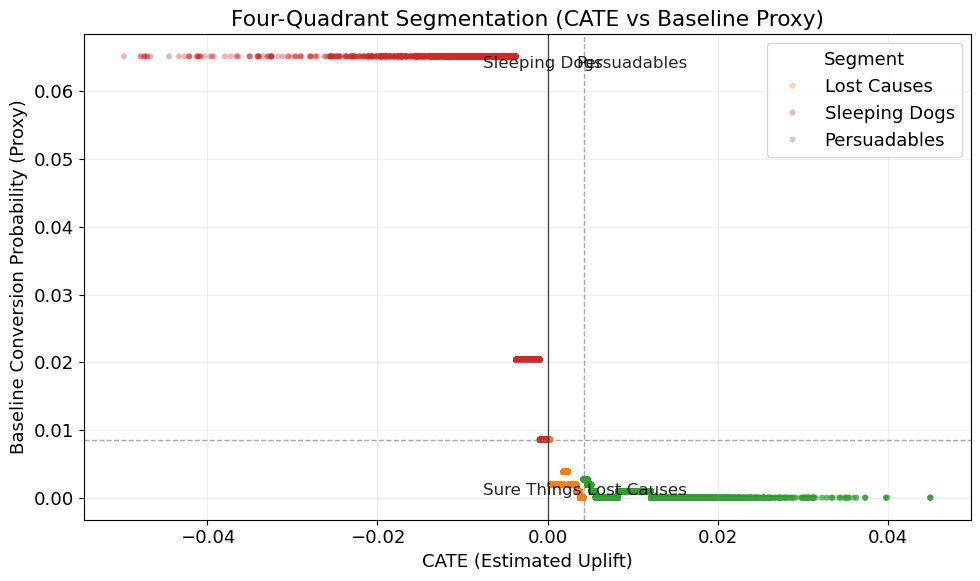

In [5]:
# ======================================================
# Section 1 (Cell 2/4): Quadrant scatter plot
# ======================================================
# X-axis: CATE
# Y-axis: baseline_prob proxy (control conversion rate within CATE bins)

plot_df = segments_df[['cate', 'baseline_prob', 'segment']].copy()
plot_df['segment'] = plot_df['segment'].astype(str)

# Threshold lines (for visualization only)
# Must match business.py segment_users() logic:
#   baseline_high = baseline_prob >= (1.0 + baseline_threshold) * control_conversion_rate
cate_threshold = float(np.percentile(cate_best, 50.0))
control_rate = float(Y[T == 0].mean())
baseline_line = (1.0 + 0.5) * control_rate

palette = {
    'Persuadables': '#2ca02c',
    'Sure Things': '#1f77b4',
    'Lost Causes': '#ff7f0e',
    'Sleeping Dogs': '#d62728',
}

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x='cate',
    y='baseline_prob',
    hue='segment',
    palette=palette,
    alpha=0.35,
    s=18,
    linewidth=0,
)

plt.axvline(0.0, color='black', linewidth=1, alpha=0.7)
plt.axvline(cate_threshold, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(baseline_line, color='gray', linestyle='--', linewidth=1, alpha=0.7)

plt.title('Four-Quadrant Segmentation (CATE vs Baseline Proxy)')
plt.xlabel('CATE (Estimated Uplift)')
plt.ylabel('Baseline Conversion Probability (Proxy)')
plt.grid(alpha=0.20)
plt.legend(title='Segment', loc='best')
plt.tight_layout()

# Label quadrants (rough positioning)
x_left = float(np.quantile(plot_df['cate'], 0.02))
x_right = float(np.quantile(plot_df['cate'], 0.98))
y_low = float(np.quantile(plot_df['baseline_prob'], 0.02))
y_high = float(np.quantile(plot_df['baseline_prob'], 0.98))
plt.text(x_right, y_high, 'Persuadables', ha='right', va='top', fontsize=12, alpha=0.85)
plt.text(x_left, y_high, 'Sleeping Dogs', ha='left', va='top', fontsize=12, alpha=0.85)
plt.text(x_right, y_low, 'Lost Causes', ha='right', va='bottom', fontsize=12, alpha=0.85)
plt.text(x_left, y_low, 'Sure Things', ha='left', va='bottom', fontsize=12, alpha=0.85)

out = figures_dir / 'fig_07_quadrant_scatter.png'
plt.savefig(out, dpi=150, bbox_inches='tight')
print(f'.png saved: {out}')
plt.show()